In [ ]:
%%capture
import random
import numpy as np
from tqdm import tqdm
import string
import nltk
nltk.download('all')
from  nltk.text import Text,ConcordanceIndex
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora #Reuters corpus
!git clone https://github.com/LGDoor/Dump-of-Simple-English-Wiki.git
!tar xvzf /content/Dump-of-Simple-English-Wiki/corpus.tgz #Simplewiki corpus


In [ ]:
#Helper functions and globals
from nltk.corpus import stopwords

concordance_window = 5
stop_words = set(stopwords.words('english')+"is I the we why how what when where us a an".split())
remove = string.digits+string.punctuation

animal_vocab = 'monkey;lion;tiger;shark;bear;horse;cat;dog;cow;pig'.split(';')
bird_vocab = 'pigeon;robin;crow;raven;eagle;vulture;albatross;parrot;sparrow;hawk'.split(';')
source_vocab = animal_vocab+bird_vocab

def seed(arg=0):
  np.random.seed(arg)

# def clean(s):
#   remove = string.digits+string.punctuation
#   filterf = lambda x: ((x not in stop_words) and (not x.isspace()) and (x!=""))
#   return list(filter(filterf, [x.translate(str.maketrans('', '', remove)).lower() for x in s]))

def clean(s):
  s = s.translate(str.maketrans('', '', remove))
  filterf = lambda x: ((x not in stop_words) and (not x.isspace()) and (x!=""))
  return ' ' .join(filter(filterf,s.split())).lower()

def clean_c(corpus,check=False):
  if not check:
    return [Text(clean(' '.join(x)).split()) for x in corpus]
  else:
    return [Text(clean(x).split()) for x in corpus]



In [ ]:
from nltk.corpus import brown, reuters
from nltk.tokenize import word_tokenize, sent_tokenize
brownc = clean_c(brown.sents())
reutersc = clean_c(reuters.sents())
with open('/content/corpus.txt', 'r') as file:
  wikitext = file.read().replace('\n', ' ')
wikic = clean_c(sent_tokenize(wikitext),True)
corpora = [brownc] # , reutersc, wikic

In [ ]:
def n_concordance_h(text,phrase,left_margin=5,right_margin=5):
    phraseList=phrase.split(' ')

    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())

    #Find the offset for each token in the phrase
    offsets=[c.offsets(x) for x in phraseList]
    offsets_norm=[]
    #For each token in the phraselist, find the offsets and rebase them to the start of the phrase
    for i in range(len(phraseList)):
        offsets_norm.append([x-i for x in offsets[i]])

    intersects=set(offsets_norm[0]).intersection(*offsets_norm[1:])

    concordance_txt = ([text.tokens[list(map(lambda x: x-left_margin if (x-left_margin)>0 else 0,[offset]))[0]:offset+len(phraseList)+right_margin] for offset in intersects])

    outputs=[''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]
    return outputs

def n_concordance(corpus, word, margin=5):
  return list(filter(lambda x:len(x)>0,[n_concordance_h(x,word,left_margin=5,right_margin=5) for x in corpus]))

In [ ]:
# def n_concordance_h(text,word,left_margin=5,right_margin=5):
#     c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
#     offset = c.offsets(word)
#     if(len(offset)==0): return []
#     offset = max(offset[0]-left_margin,0)
#     concordance_txt = text.tokens[offset:offset+1+right_margin]
#     outputs=''.join([x+' ' for x in concordance_txt])
#     return [outputs]

# def n_concordance(corpus, word, margin=5):
#   return list(filter(lambda x:len(x)>0,[n_concordance_h(x,word,left_margin=margin,right_margin=margin) for x in corpus]))

In [ ]:
brownc[:2],reutersc[:2],wikic[:2]

([<Text: the fulton county grand jury said friday investigation...>,
  <Text: the jury said termend presentments city executive committee...>],
 [<Text: asian exporters fear damage from u s japan...>,
  <Text: they told reuter correspondents asian capitals u s...>],
 [<Text: april april fourth month year days...>,
  <Text: the name april comes latin word aperire means...>])

In [ ]:
print(*n_concordance(brownc,'monkey'),sep="\n")

['ladys hip visiting central park monkey house ']
['considerations alone may conceivably different monkey horse ']
['for example marked susceptibility monkey respiratory infection might related delicate ']
['this especially dog cat monkey used view marked anatomical differences ']
['type dog cat monkey ']
['forms emotional arousal could elicited monkey a seeing monkey b rabbit ', 'could elicited monkey a seeing monkey b rabbit emotional stress ']
['previously extinguished conditioned reaction restored monkey a associated typical signs emotional ']
['look like large skinny old monkey ']


In [ ]:
# text = text2
# c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
# print([text.tokens[offset+1] for offset in c.offsets(w)])

In [ ]:
class Vocab():
  def __init__(self, w2i={},i2w={},cur=0):
    self.w2i = w2i
    self.i2w = i2w
    self.cur = cur

  def add(self, word):
    if(type(word)==str):
      if word not in self.w2i:
        self.w2i[word] = self.cur
        self.i2w[self.cur] = word
        self.cur+=1
    else:
      for x in word:
        self.add(x)

vocab = Vocab()
contexts = {}

for _,word in tqdm(enumerate(source_vocab)):
  vocab.add(word)
  contexts[word] = set()
  for corpus in corpora:
    getc = n_concordance(corpus,word)
    for s in getc:
      s1 = s[0].split()
      vocab.add(s1)
      contexts[word]= contexts[word].union(s1) # CHANGED HERE 1

20it [00:14,  1.37it/s]


In [ ]:
print('Total Words:',vocab.cur)
s = 0
for k,v in contexts.items():
  # s = set([x.lower() for x in v if x not in stop_words])
  print(k,len(v))
  s+=len(v)
  # print(s)
print(s)

Total Words: 1673
monkey 53
lion 110
tiger 50
shark 0
bear 384
horse 582
cat 131
dog 385
cow 175
pig 56
pigeon 21
robin 16
crow 16
raven 0
eagle 33
vulture 29
albatross 0
parrot 7
sparrow 0
hawk 79
2127


In [ ]:
print(*contexts.items(),sep = "\n")

('monkey', {'conceivably', 'this', 'reaction', 'like', 'anatomical', 'conditioned', 'related', 'example', 'rabbit', 'marked', 'b', 'alone', 'a', 'respiratory', 'especially', 'associated', 'could', 'considerations', 'horse', 'previously', 'monkey', 'view', 'for', 'cat', 'elicited', 'hip', 'signs', 'look', 'large', 'typical', 'old', 'used', 'skinny', 'delicate', 'central', 'may', 'arousal', 'dog', 'forms', 'house', 'emotional', 'extinguished', 'visiting', 'seeing', 'type', 'park', 'susceptibility', 'infection', 'restored', 'might', 'differences', 'different', 'ladys'})
('lion', {'working', 'trail', 'cowpony', 'nothing', 'faster', 'pack', 'till', 'unless', 'confining', 'went', 'social', 'course', 'hair', 'responded', 'novel', 'promise', 'a', 'tracks', 'manager', 'future', 'standing', 'outrun', 'outside', 'oersted', 'start', 'nice', 'ground', 'john', 'face', 'it', 'pharmacy', 'heavy', 'of', 'day', 'smell', 'crazy', 'lamb', 'lie', 'lion', 'distance', 'rock', 'paralyzed', 'ruined', 'visiting

In [ ]:
def InterClusterMeans(weight_vecs):
  animal_cluster = [weight_vecs[x] for x in animal_vocab]
  bird_cluster = [weight_vecs[x] for x in bird_vocab]
  animal_mean, bird_mean = np.mean(animal_cluster,axis=0), np.mean(bird_cluster,axis=0)
  return np.linalg.norm(animal_mean-bird_mean)

def InterClusterAll(weight_vecs):
  animal_cluster = [weight_vecs[x] for x in animal_vocab]
  bird_cluster = [weight_vecs[x] for x in bird_vocab]
  cnt,sum = 0,0
  max1 = 0
  for a in animal_cluster:
    for b in bird_cluster:
      d = np.linalg.norm(a-b)
      max1 = max(max1,d)
      sum+=d
      cnt+=1
  return max1, sum/cnt

def IntraClusterAll(weight_vecs, which):
  cluster = [weight_vecs[x] for x in animal_vocab] if which==0 else [weight_vecs[x] for x in bird_vocab]
  sum,cnt = 0,0
  max1 = 0
  for i,a in enumerate(cluster):
    for j,b in enumerate(cluster):
      if(i!=j):
        d = np.linalg.norm(a-b)
        max1 = max(max1,d)
        sum+=d
        cnt+=1
  return max1, sum/cnt


def DaviesBouldin(weight_vecs):
  animal_cluster = [weight_vecs[x] for x in animal_vocab]
  bird_cluster = [weight_vecs[x] for x in bird_vocab]
  animal_mean, bird_mean = np.mean(animal_cluster,axis=0), np.mean(bird_cluster,axis=0)
  animal_var = np.mean([np.linalg.norm(v-animal_mean)**2 for v in animal_cluster])
  bird_var = np.mean([np.linalg.norm(v-bird_mean)**2 for v in bird_cluster])
  db = (animal_var+bird_var) / np.linalg.norm(animal_mean - bird_mean)**2
  return db/2

# print('DB',DaviesBouldin(weight_vecs))

# # def Silhouette(weight_vecs):
# #   animal_cluster = [weight_vecs[x] for x in animal_vocab]
# #   bird_cluster = [weight_vecs[x] for x in bird_vocab]
# #   for i,v in enumerate(animal_cluster):


# def AdjustedRand(weight_vecs):
#   animal_cluster = [weight_vecs[x] for x in animal_vocab]
#   bird_cluster = [weight_vecs[x] for x in bird_vocab]



In [ ]:
import numpy as np
import string
# from nltk.corpus import stopwords

def softmax(x):
	"""Compute softmax values for each sets of scores in x."""
	e_x = np.exp(x - np.max(x))
	return e_x / e_x.sum()

class word2vec(object):
	def __init__(self):
		self.N = 32
		self.X_train = []
		self.y_train = []
		self.window_size = 2
		self.alpha = 0.005
		self.words = []
		self.word_index = {}

	def initialize(self,V,data):
		self.V = V
		self.W = np.random.uniform(-0.8, 0.8, (self.V, self.N))
		self.W1 = np.random.uniform(-0.8, 0.8, (self.N, self.V))

		self.words = data
		for i in range(len(data)):
			self.word_index[data[i]] = i


	def feed_forward(self,X):
		self.h = np.dot(self.W.T,X).reshape(self.N,1)
		self.u = np.dot(self.W1.T,self.h)
		#print(self.u)
		self.y = softmax(self.u)
		return self.y

	def backpropagate(self,x,t):
		e = self.y - np.asarray(t).reshape(self.V,1)
		# e.shape is V x 1
		dLdW1 = np.dot(self.h,e.T)
		X = np.array(x).reshape(self.V,1)
		dLdW = np.dot(X, np.dot(self.W1,e).T)
		self.W1 = self.W1 - self.alpha*dLdW1
		self.W = self.W - self.alpha*dLdW

	def train(self,epochs):
		losses = []
		for x in tqdm(range(1,epochs)):
			self.loss = 0
			self.X_train,self.y_train = zip(*random.shuffle(zip(self.X_train,self.y_train)))
			for j in range(len(self.X_train)):
				self.feed_forward(self.X_train[j])
				self.backpropagate(self.X_train[j],self.y_train[j])
				C = 0
				for m in range(self.V):
					if(self.y_train[j][m]):
						self.loss += -1*self.u[m][0]
						C += 1
				self.loss += C*np.log(np.sum(np.exp(self.u)))
			check = {}
			self.collect_weights(check)
			print('DB:',DaviesBouldin(check))
			print('InterMeans:',InterClusterMeans(check))
			temp = InterClusterAll(check)
			print('InterAllMax:',temp[0],'InterAllMean',temp[1])
			print('IntraAll Animals:',IntraClusterAll(check,0))
			print('IntraAll Birds:',IntraClusterAll(check,1))
			print("epoch ",x, " loss = ",self.loss)
			losses.append(self.loss)
			self.alpha *= 1/( (1+self.alpha*x) )
		return np.array(losses)

	def collect_weights(self,weight_vecs):
		for word in source_vocab:
			center_word = [0 for x in range(len(vocab.w2i))]
			center_word[vocab.w2i[word]] = 1
			# prediction = self.feed_forward(center_word)
			weight_vecs[word] = np.dot(self.W.T,center_word).reshape(self.N,1)

	def predict(self,word,number_of_predictions):
		if word in self.words:
			index = self.word_index[word]
			X = [0 for i in range(self.V)]
			X[index] = 1
			prediction = self.feed_forward(X)
			print('Check\n',prediction)
			output = {}
			for i in range(self.V):
				output[prediction[i][0]] = i

			top_context_words = []
			for k in sorted(output,reverse=True):
				top_context_words.append(self.words[output[k]])
				if(len(top_context_words)>=number_of_predictions):
					break

			return top_context_words
		else:
			print("Word not found in dictionary")


In [ ]:
# TO BE RUN
from tqdm.notebook import tqdm

def prepare_data_for_training(w2v):
    for word in source_vocab:
        center_word = [0 for x in range(len(vocab.w2i))]
        center_word[vocab.w2i[word]] = 1
        context_words_rep = [0 for x in range(len(vocab.w2i))]
        if len(contexts[word])<4:
            continue
        context_words = np.array(list(contexts[word]), dtype = str)
        # print(context_words)
        # print(type(context_words),context_words.shape)
        c_words = context_words[np.random.choice(len(context_words),4,replace=False)]
        for ele in c_words:
            # print(word,c_words,"ddsdf")
            context_words_rep[vocab.w2i[ele]] = 1
            w2v.X_train.append(center_word)
            w2v.y_train.append(context_words_rep)
    V = len(vocab.w2i)
    data = list(vocab.w2i.keys())
    #for i in range(len(words)):
    w2v.initialize(V,data)
    # print("training data x,y", w2v.X_train,w2v.y_train)
    return w2v.X_train,w2v.y_train

In [ ]:
def cosineSimilarity(v1,v2):
    return np.dot(v1.T,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

  0%|          | 0/299 [00:00<?, ?it/s]

DB: 2.916184923845478
InterMeans: 1.4246587662718246
InterAllMax: 4.550517523162467 InterAllMean 3.705145406754968
IntraAll Animals: (4.140617065999394, 3.568705528776734)
IntraAll Birds: (4.5620855715445146, 3.6518659665058832)
epoch  1  loss =  513.4863587441288
DB: 2.921514459254935
InterMeans: 1.4227973603576267
InterAllMax: 4.542570741299715 InterAllMean 3.703218557588136
IntraAll Animals: (4.134680536437994, 3.5678895794151693)
IntraAll Birds: (4.554257758535418, 3.6498750868512504)
epoch  2  loss =  509.4121828316695
DB: 2.926712450473698
InterMeans: 1.4211831375873027
InterAllMax: 4.535304519541632 InterAllMean 3.701850117816088
IntraAll Animals: (4.129399444054011, 3.5676771293830654)
IntraAll Birds: (4.547179375127221, 3.6483496515211056)
epoch  3  loss =  505.38059302571344
DB: 2.9317546021083736
InterMeans: 1.419815086057232
InterAllMax: 4.5287304267295765 InterAllMean 3.7010264747280646
IntraAll Animals: (4.124776676196028, 3.5680470881463173)
IntraAll Birds: (4.5408586871

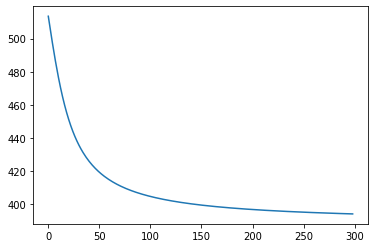

In [ ]:
# OUR CELL FOR TRAINING
np.random.seed(1)
w2v = word2vec()
epochs = 300
prepare_data_for_training(w2v)
losses = w2v.train(epochs)
weight_vecs = {}
w2v.collect_weights(weight_vecs)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
cosineSimilarity(weight_vecs["cow"],weight_vecs["horse"])

array([[-0.06275902]])

In [ ]:
cosineSimilarity(weight_vecs["dog"],weight_vecs["cat"])

array([[0.1091131]])

In [ ]:
cosineSimilarity(weight_vecs["cow"],weight_vecs["vulture"])

array([[-0.01746292]])

In [ ]:

animal_cluster = [weight_vecs[x] for x in animal_vocab]
bird_cluster = [weight_vecs[x] for x in bird_vocab]
cnt,sum = 0,0
max1 = 0
for i,a in enumerate(animal_cluster):
  for j,b in enumerate(bird_cluster):
    d = np.linalg.norm(a-b)
    if(d>max):

    sum+=d
    cnt+=1



cluster = [weight_vecs[x] for x in animal_vocab] if which==0 else [weight_vecs[x] for x in bird_vocab]
sum,cnt = 0,0
max1 = 0
for i,a in enumerate(cluster):
  for j,b in enumerate(cluster):
    if(i!=j):
      d = np.linalg.norm(a-b)
      max1 = max(max1,d)
      sum+=d
      cnt+=1
return max1, sum/cnt

In [ ]:
# def preprocessing(corpus):
#     stop_words = set(stopwords.words('english'))
#     training_data = []
#     sentences = corpus.split(".")
#     for i in range(len(sentences)):
#         sentences[i] = sentences[i].strip()
#         sentence = sentences[i].split()
#         x = [word.strip(string.punctuation) for word in sentence
#                                      if word not in stop_words]
#         x = [word.lower() for word in x]
#         training_data.append(x)
#     return training_data


# def prepare_data_for_training(sentences,w2v):
#     data = {}
#     for sentence in sentences:
#         for word in sentence:
#             if word not in data:
#                 data[word] = 1
#             else:
#                 data[word] += 1
#     V = len(data)
#     data = sorted(list(data.keys()))
#     vocab = {}
#     for i in range(len(data)):
#         vocab[data[i]] = i

#     #for i in range(len(words)):
#     for sentence in sentences:
#         for i in range(len(sentence)):
#             center_word = [0 for x in range(V)]
#             center_word[vocab[sentence[i]]] = 1
#             context = [0 for x in range(V)]

#             for j in range(i-w2v.window_size,i+w2v.window_size):

#                 if i!=j and j>=0 and j<len(sentence):
#                     print(sentence[i],sentence[j])
#                     context[vocab[sentence[j]]] += 1
#             w2v.X_train.append(center_word)
#             w2v.y_train.append(context)
#     w2v.initialize(V,data)
#     # print("training data x,y", w2v.X_train,w2v.y_train)
#     return w2v.X_train,w2v.y_train